#<center>CSCI4192 Project</center>

## Introduction

*  Received signal strength indication (RSSI) fingerprinting is commonly used for indoor localization. In this method, a radio map is created using RSS values in the offline phase. In the online phase, a machine learning algorithm is used to find the best match between the observed RSS values and the RSS values in the radio map. 
* Ensemble learning is a learning strategy that combines a set of models to achieve better performance than an individual model on average. In order to achieve better performance, I will use voting and bagging to see if these ensemble learning strategies perform better than individual machine learning models.


## Data pre-processing and understanding

###The offline dataset is simulated by using Matlab, and the simulation source code  was obtained from https://github.com/jiangqideng/codeInBlogs/tree/master/IP_raytracing

In [ ]:
import numpy as np
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from itertools import combinations 
from scipy import stats
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso

In [ ]:
offline_data = scio.loadmat('/content/offline_data_uniform.mat')
offline_location, offline_rss = offline_data['offline_location']/10, offline_data['offline_rss']
online_data = scio.loadmat('/content/online_data.mat')
online_location, online_rss = online_data['trace']/10, online_data['rss']

In [ ]:
colums=["rss1","rss2","rss3","rss4","rss5","rss6"]
rss_df=pd.DataFrame(data=offline_rss,columns=colums)
colums2=["x","y"]
location_df=pd.DataFrame(data=offline_location,columns=colums2)
df = pd.concat( [rss_df, location_df], axis=1 )
#convert the data type of target values from float to integer
df['x']=df['x'].astype('int')
df['y']=df['y'].astype('int')
colums=["rss1","rss2","rss3","rss4","rss5","rss6"]
rss_df = pd.DataFrame(data=online_rss,columns=colums)
colums2=["x","y"]
online_location_df=pd.DataFrame(data=online_location,columns=colums2)
df_online = pd.concat( [rss_df, online_location_df], axis=1 )

### The room layout

* The offline fingerprint data was simulated in a 20m x 15m x 4m room, in which six 2.4GHz WiFi Access Points were uniformly fixed in the room. The interval of each grid line is half a meter.

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, 210, 5)
minor_ticks = np.arange(0, 160, 5)
ax.set_xticks(major_ticks)
ax.set_yticks(minor_ticks)
ax.grid(which='both')
x=[10,100,190,10,100,190]
y=[10,10,10,140,140,140]
point_x=df["x"]
point_y=df["y"]
ax.scatter(point_x,point_y,c='black',s=10,label='sample points')
ax.scatter(x,y,c='r',s=100)
ax.grid(which='minor', alpha=0.5)
ax.grid(which='major', alpha=0.5)
aps=["AP1","AP2","AP3","AP4","AP5","AP6"]
ax.hlines(y=150, xmin=0, xmax=200, linewidth=2, color='b')
ax.hlines(y=0, xmin=0, xmax=200, linewidth=2, color='b')
ax.vlines(x=0,ymin=0, ymax=150, linewidth=2, color='b')
ax.vlines(x=200,ymin=0, ymax=150, linewidth=2, color='b')
for i,txt in enumerate(aps):
    ax.annotate(txt,(x[i],y[i]))
ax.set_xlabel('length(dm)')
ax.set_ylabel('width(dm)')
ax.set_title('Space partion and Fingerprint in a 20m * 15m Room')
##ax.plot(df_online.iloc[:,-2],df_online.iloc[:,-1],color='green')
plt.show()

NameError: ignored

In [ ]:
df_online

###Deal with null and infinite data

In [ ]:
#train dataset
check1 = np.isinf(df).any()
check2 = df.isnull().any()
print("check if the dataset has infinite data:")
print(check1)
print("check if the dataset has null data:")
print(check2)

check if the dataset has infinite data:
rss1     True
rss2     True
rss3     True
rss4     True
rss5     True
rss6     True
x       False
y       False
dtype: bool
check if the dataset has null data:
rss1    False
rss2    False
rss3    False
rss4    False
rss5    False
rss6    False
x       False
y       False
dtype: bool


In [ ]:
#test dataset
check1 = np.isinf(df_online).any()
check2 = df_online.isnull().any()
print("check if the dataset has infinite data:")
print(check1)
print("check if the dataset has null data:")
print(check2)

check if the dataset has infinite data:
rss1    False
rss2    False
rss3    False
rss4    False
rss5    False
rss6    False
x       False
y       False
dtype: bool
check if the dataset has null data:
rss1    False
rss2    False
rss3    False
rss4    False
rss5    False
rss6    False
x       False
y       False
dtype: bool


In [ ]:
df_new=df.replace([np.inf, -np.inf], np.nan).dropna()
df_new = df_new.reset_index(drop=True)
df_new

,rss1,rss2,rss3,rss4,rss5,rss6,x,y
0,-36.863742,-59.318714,-58.292279,-56.141269,-52.743088,-70.228864,5,5
1,-30.109282,-60.500264,-56.480286,-63.048431,-52.844564,-61.179564,10,5
2,-34.430014,-63.324873,-55.468547,-57.093329,-58.167865,-66.169181,15,5
3,-33.407304,-63.149887,-54.886736,-60.338367,-76.538737,-63.086565,20,5
4,-37.223731,-74.901209,-54.559635,-58.254873,-57.048443,-57.203010,25,5
...,...,...,...,...,...,...,...,...
1120,-57.203010,-57.048443,-58.254873,-54.559635,-74.901209,-37.223731,175,145
1121,-63.086565,-76.538737,-60.338367,-54.886736,-63.149887,-33.407304,180,145
1122,-66.169181,-58.167865,-57.093329,-55.468547,-63.324873,-34.430014,185,145
1123,-61.179564,-52.844564,-63.048431,-56.480286,-60.500264,-30.109282,190,145


In [ ]:
df_new.describe()

,rss1,rss2,rss3,rss4,rss5,rss6,x,y
count,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,-55.600311,-54.201387,-55.600311,-55.600311,-54.201387,-55.600311,100.000000,75.000000
std,6.257909,6.734366,6.257909,6.257909,6.734366,6.257909,56.192191,41.693467
min,-83.468841,-79.970968,-83.468841,-83.468841,-79.970968,-83.468841,5.000000,5.000000
25%,-58.891419,-57.590917,-58.891419,-58.891419,-57.590917,-58.891419,50.000000,40.000000
50%,-55.401526,-53.897168,-55.401526,-55.401526,-53.897168,-55.401526,100.000000,75.000000
75%,-52.690379,-50.587245,-52.690379,-52.690379,-50.587245,-52.690379,150.000000,110.000000
max,-29.606275,-29.026959,-29.606275,-29.606275,-29.026959,-29.606275,195.000000,145.000000


### Data Exploration

* Plot the distribution of the attributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefa8eaaf50>,
      dtype=object)

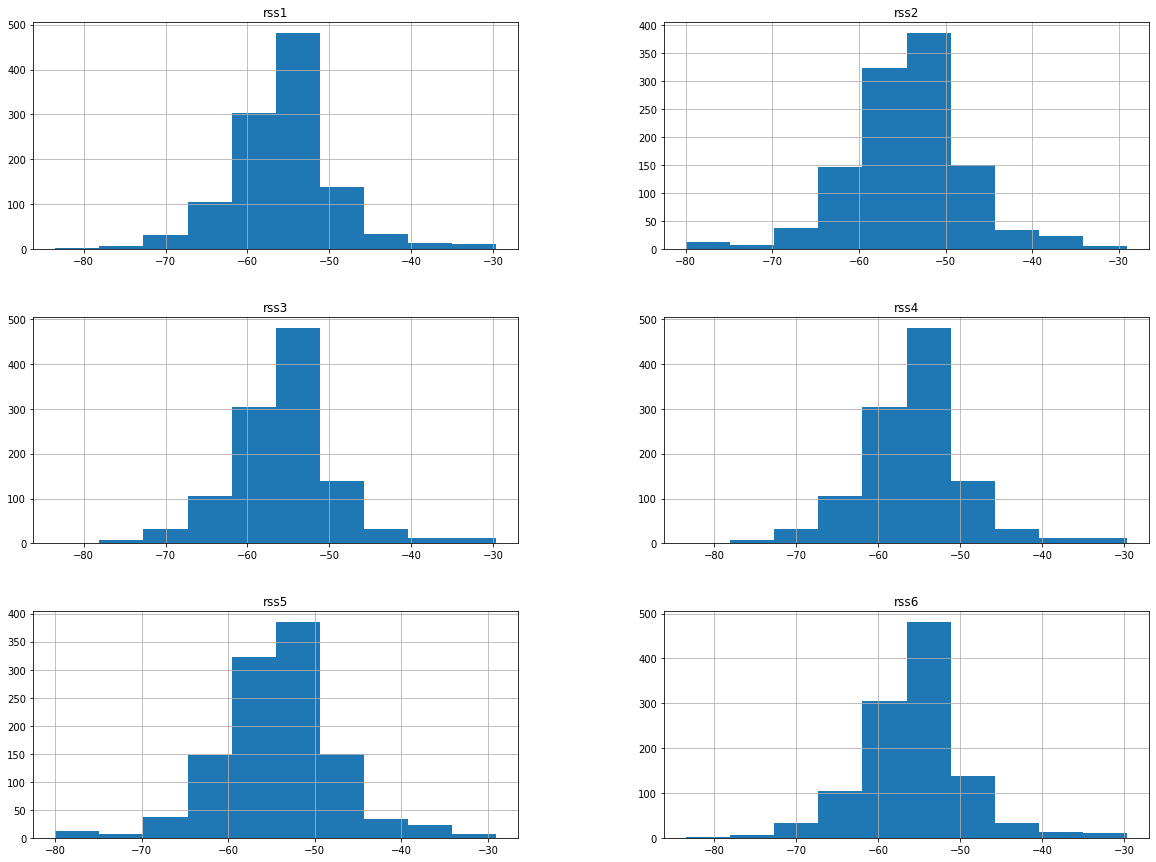

In [ ]:
df_new.iloc[:,:6].hist(figsize=(20,15))

* From the above graphs, we can observe that the distribution of each access point's RSS values approximately follows the normal distribution.

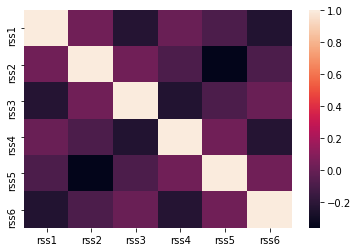

In [ ]:
import seaborn as sns
sns.heatmap(df_new.iloc[:,0:-2].corr())

* From the above co-relation heat-map and the layout of the room, we can find the overlap of the signals is directly proportional to the distance by which they are kept apart.

## Comparative study on machine learning algorithms for RSSI-based Fingerprinting

### Build model with classification algorithms

In [ ]:
X_train = df_new.iloc[:, 0:-2]
y_train = df_new.iloc[:, -2:]
X_test = df_online.iloc[:, 0:-2]
y_test = df_online.iloc[:, -2:]

In [ ]:
#define a function that calculates the euclidean distance between the predict coordinates and the actual coordinates
def accuracy(predict,actual):
  return np.mean(np.sqrt(np.sum((predict-actual)**2,1)))

#### Gaussian Naive Bayes classifier

* Since the distribution of attributes approximately obeys the law of normal distribution, we try the Gaussian Naive Bayes algorithm as a start.
*$$P\left(feature_{i} | label\right)=\frac{1}{\sqrt{2 \pi \sigma_{label}^{2}}} \exp \left(-\frac{\left(feature_{i}-\mu_{label}\right)^{2}}{2 \sigma_{label}^{2}}\right)$$

where $\mu$ - mean, $\sigma^2$ - variance

In Scikit-Learn this classifier is implemented as ``sklearn.naive_bayes.GaussianNB`` estimator:

In [ ]:
#Since the target value is 2d, we use MultiOutputClassifier.
#Before fitting the model, we first normalize the data.
pipe_gn = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputClassifier(GaussianNB()))])
pipe_gn.fit(X_train,y_train)
gn_predict=pipe_gn.predict(X_test)
acc_gn=accuracy(gn_predict,y_test)/10
print('Mean error distance of Gaussian Naive Bayes classifier: '+str(acc_gn)+'m')

Mean error distance of Gaussian Naive Bayes classifier: 3.397368093750886m


#### K-Nearest Neighbors classifier

* With the K-Neatest Neighbor technique, each column in the offline phase dataset is a vector of observed RSS values, A=<rss1,rss2,...,rss6>. In the online phase, an observed point B=<rss1',rss2',...,rss6'>, which is a vector of observed RSS values, is compared with the vectors in the offline phase by the distance function. Then use K nearest neighbors of B to obtain the location of B. (voting)

* The distance function can be Manhattan, Euclidean, etc.

Manhattan: $$\Large d(A,B)=\sum_{i=1}^{n}\mid A_{i}- B_{i} \mid $$
Euclidean: $$\Large d(A,B)={\sqrt{ (A_{i}- B_{i})^{2}}}$$

* In Scikit-Learn this classifier is implemented as ``sklearn.neighbors.KNeighborsClassifier`` estimator.
* We can use weighted distance for prediction, *uniform* stands for equal weights, *distance* stands for weight points by the inverse of their distance.


In [ ]:
pipe_knn = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputClassifier(KNeighborsClassifier()))])

grid_param_knn = {
    'clf__estimator__n_neighbors': np.arange(1,10), 'clf__estimator__metric': ['euclidean','manhattan'], 'clf__estimator__weights': ['uniform','distance']
}
#use 5 fold corss validation to evaluate the model
gs_knn = (GridSearchCV(estimator=pipe_knn, 
                      param_grid=grid_param_knn, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_knn.fit(X_train,y_train)
print(gs_knn.best_estimator_)   

knn_predict=gs_knn.predict(X_test)
acc_knnc=accuracy(knn_predict,y_test)/10
print('Mean error distance of K-Nearest Neighbors classifier: '+str(acc_knnc)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                                      leaf_size=30,
                                                                      metric='manhattan',
                                                                      metric_params=None,
                                                                      n_jobs=None,
                                                                      n_neighbors=9,
                                                                      p=2,
                                                                      weights='distance'),
                                       n_jobs=None))],
         verbose=False)
Mean error distance of K-Nearest Neighbors classifier: 3.3380587100943755m


After 5 fold corss valisdation, we can obtain the "optimal" hyperparameter.

#### Support Vector classifier

* SVM solves this problem by finding the decision boundary that maximizes the decision margin. Support vectors are on the margin.
* We will use ``sklearn.svm.SVC`` estimator from Scikit-learn to train an SVM model.
* The *linear* means the decision boundary is linear and the *rbf* is a kernel function that can transform the data points into a higher dimension to find the boundary, *rbf* is useful when data is not linearly separable.
* *C* stands for the strength of the penalty, which aims to avoid overfitting. It is 𝐿2 Regularization.

In [ ]:
pipe_svc = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputClassifier(SVC()))])

grid_param_svc = {
    'clf__estimator__kernel': ['linear', 'rbf'], 'clf__estimator__C':np.arange(0,10)
}

gs_svc = (GridSearchCV(estimator=pipe_svc, 
                      param_grid=grid_param_svc, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_svc.fit(X_train,y_train)
print(gs_svc.best_estimator_)   
svc_predict=gs_svc.predict(X_test)
acc_svc=accuracy(svc_predict,y_test)/10
print('Mean error distance of Support Vector classifier: '+str(acc_svc)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputClassifier(estimator=SVC(C=2, break_ties=False,
                                                     cache_size=200,
                                                     class_weight=None,
                                                     coef0=0.0,
                                                     decision_function_shape='ovr',
                                                     degree=3, gamma='scale',
                                                     kernel='rbf', max_iter=-1,
                                                     probability=False,
                                                     random_state=None,
                                                     shrinking=True, tol=0.001,
                                                     verbose=False),
                                      

After 5 fold corss valisdation, we can obtain the "optimal" hyperparameter.

### Build model with regression algorithms

#### Ridge regressor

* Ridge regressor is a linear regressor with 𝐿2 Regularization. L2 penalty proceeds by penalizing the sum of squares of the model coefficients.
* This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator, *alpha* stands for the strength of the penalty.

In [ ]:
#Since the target value is 2d, we use MultiOutputRegressor.
pipe_ridge = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputRegressor(Ridge()))])

grid_param_ridge = {
    'clf__estimator__alpha': np.arange(1,10)
}

gs_ridge = (GridSearchCV(estimator=pipe_ridge, 
                      param_grid=grid_param_ridge, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_ridge.fit(X_train,y_train)
print(gs_ridge.best_estimator_)   

ridge_predict=gs_ridge.predict(X_test)
acc_ridge=accuracy(ridge_predict,y_test)/10
print('Mean error distance of Ridge regressor: '+str(acc_ridge)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputRegressor(estimator=Ridge(alpha=1, copy_X=True,
                                                      fit_intercept=True,
                                                      max_iter=None,
                                                      normalize=False,
                                                      random_state=None,
                                                      solver='auto',
                                                      tol=0.001),
                                      n_jobs=None))],
         verbose=False)
Mean error distance of Ridge regressor: 4.0110019399834425m


After 5 fold corss valisdation, we can obtain the "optimal" hyperparameter. (alpha=3)

#### K-Nearest Neighbors regressor

* One distinction between K-Nearest Neighbors Regressor and K-Nearest Neighbors classifier is that the value of prediction is obtained by averaging the K nearest neighbors' values.
* This type of penalized model is built into Scikit-Learn with the ``KNeighborsRegressor`` estimator, *alpha* stands for the strength of the penalty.

In [ ]:
pipe_knnr = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputRegressor(KNeighborsRegressor()))])

grid_param_knnr = {
    'clf__estimator__n_neighbors': np.arange(1,10), 'clf__estimator__metric': ['euclidean','manhattan'], 'clf__estimator__weights': ['uniform','distance']
}

gs_knnr = (GridSearchCV(estimator=pipe_knnr, 
                      param_grid=grid_param_knnr, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_knnr.fit(X_train,y_train)
print(gs_knnr.best_estimator_)   

knnr_predict=gs_knnr.predict(X_test)
acc_knnr=accuracy(knnr_predict,y_test)/10
print('Mean error distance of Ridge regressor: '+str(acc_knnr)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto',
                                                                    leaf_size=30,
                                                                    metric='euclidean',
                                                                    metric_params=None,
                                                                    n_jobs=None,
                                                                    n_neighbors=9,
                                                                    p=2,
                                                                    weights='distance'),
                                      n_jobs=None))],
         verbose=False)
Mean error distance of Ridge regressor: 2.570638521641137m


After 5 fold corss valisdation, we can obtain the "optimal" hyperparameter.

#### Support Vector regressor

* In SVR, the support vectors are the farthest points from the decision boundary, and we need to find the boundary that can minimize the margin.

In [ ]:
pipe_svr = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputRegressor(SVR()))])

grid_param_svr = {
    'clf__estimator__kernel': ['linear', 'rbf'], 'clf__estimator__C':np.arange(1,10)
}

gs_svr = (GridSearchCV(estimator=pipe_svr, 
                      param_grid=grid_param_svr, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_svr.fit(X_train,y_train)
print(gs_svr.best_estimator_)   
svr_predict=gs_svr.predict(X_test)
acc_svr=accuracy(svr_predict,y_test)/10
print('Mean error distance of Ridge regressor: '+str(acc_svr)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputRegressor(estimator=SVR(C=9, cache_size=200,
                                                    coef0=0.0, degree=3,
                                                    epsilon=0.1, gamma='scale',
                                                    kernel='rbf', max_iter=-1,
                                                    shrinking=True, tol=0.001,
                                                    verbose=False),
                                      n_jobs=None))],
         verbose=False)
Mean error distance of Ridge regressor: 2.706364718274723m


After 5 fold corss valisdation, we can obtain the "optimal" hyperparameter. (kernel='rbf',C=9)

## Ensemble Method for RSSI-based Fingerprinting

###Voting

Voting is a simple ensemble learning strategy. It works by combining the predictions from multiple models. In classification problems, predictions are the majority vote of classification models. In regression problems, predictions are the average of regression models.
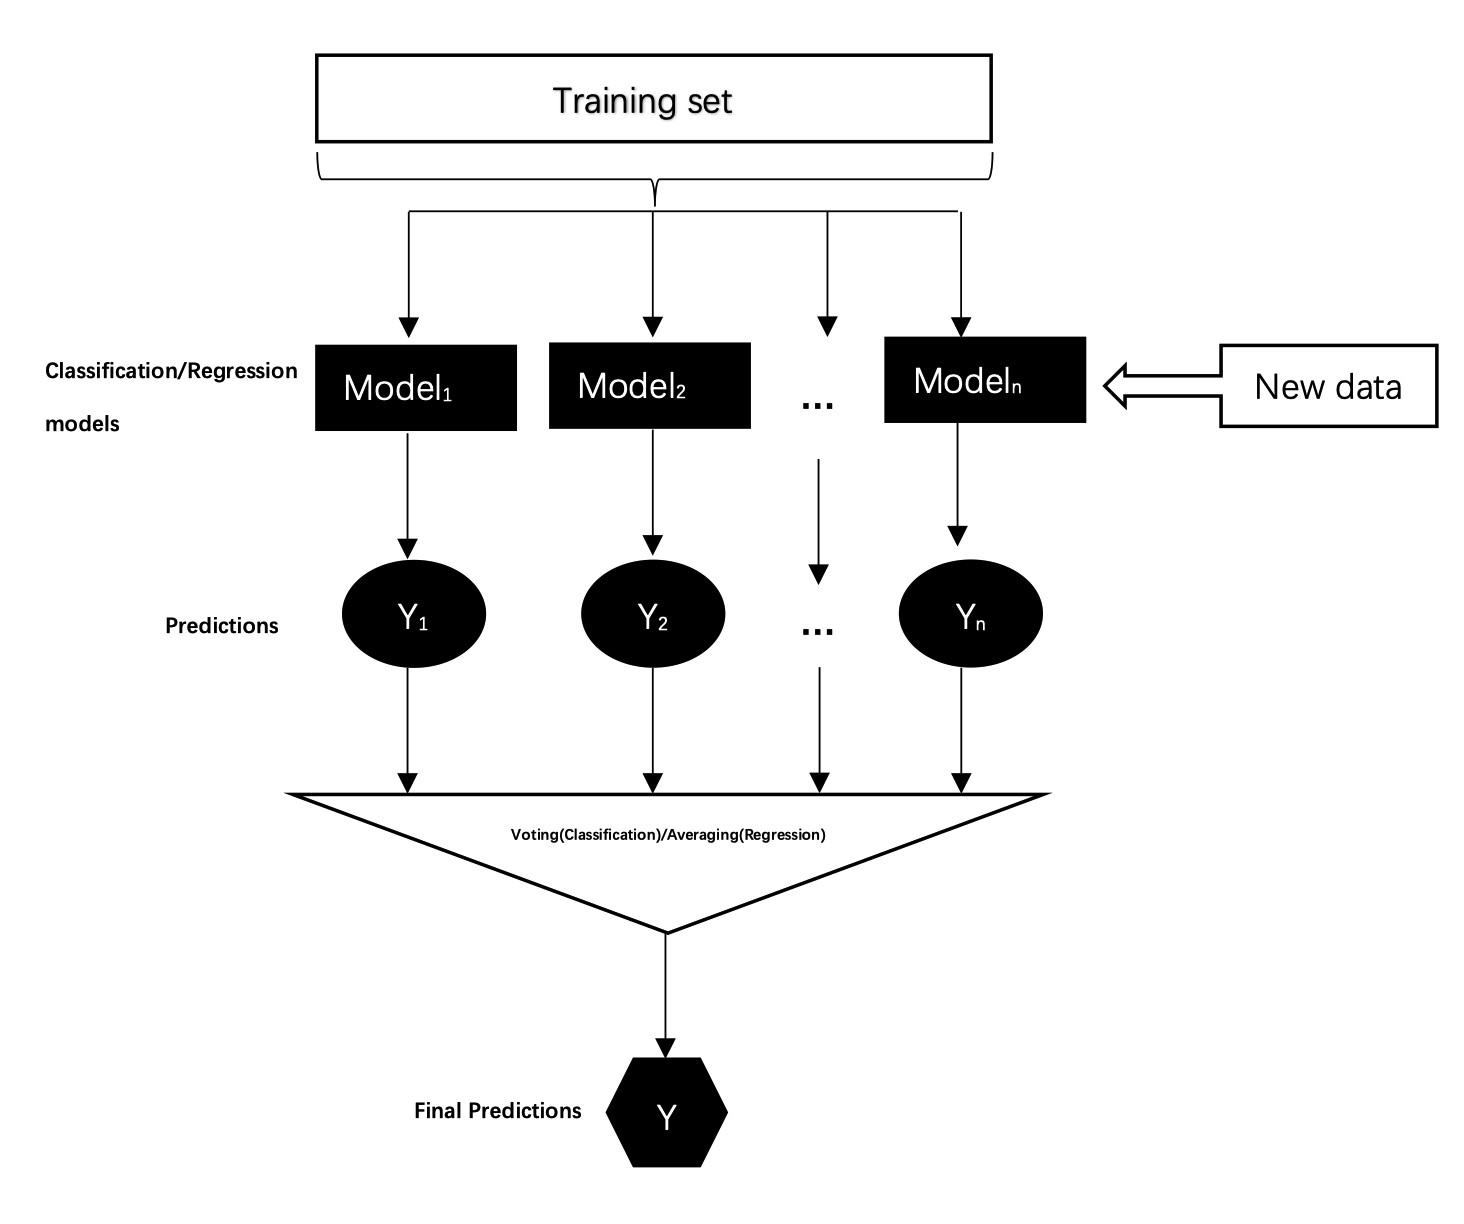

#### Classification Voting Ensemble

* There are two approaches to the voting ensemble for classification problems: hard voting and soft voting.
* Hard Voting : It returns the class label as the largest sum of the vote.
* Soft Voting : It returns the class label as the max of the sum of predicted probabilities.
* Since SVM algorithm uses a decision boundary for classification problems, it cannot return probability estimates for test data. In this scenario, I decide to use hard voting.

In [ ]:
##Hard Voting
#define a function that returns the majority value
def max_value(values):
  a=stats.mode(values)[0][0]  
  return a
class max_voting:
  def __init__(self,estimators):
    self.estimators=estimators
  def max_predict(self,data):
    final_pred_x = []
    final_pred_y = []
    result=[]
    for i in self.estimators:
      result.append(i.predict(data))
    for i in range(0,len(result[0])):
      final_pred_x.append(max_value([value[i][0] for value in result]))
      final_pred_y.append(max_value([value[i][1] for value in result]))
    final_pred=np.dstack((final_pred_x,final_pred_y))
    final_pred=final_pred.reshape(data.shape[0],2)
    return final_pred
max_voting_model=max_voting([pipe_gn,gs_knn,gs_svc])     
max_voting_model_predict=max_voting_model.max_predict(X_test)                        
acc_hard_ensemble=accuracy(max_voting_model_predict,y_test)/10
print('Mean error distance of hard voting ensemble: '+str(acc_hard_ensemble)+'m')

Mean error distance of hard voting ensemble: 3.3205077698518766m


In [ ]:
#Algorithm validation by sklearn
c1 = GaussianNB()
c2 = KNeighborsClassifier(metric='manhattan',n_neighbors=9,weights='distance')
c3 = SVC(C=2,kernel='rbf')
voting_clf = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputClassifier(VotingClassifier(estimators=[('gnb', c1), ('knn', c2), ('svc', c3)], voting='hard')))])
voting_clf.fit(X_train,y_train)
voting_clf_predict = voting_clf.predict(X_test)
voting_clf_predict_acc = accuracy(voting_clf_predict,y_test)/10
print('Mean error distance of hard voting ensemble: '+str(voting_clf_predict_acc)+'m')

Mean error distance of hard voting ensemble: 3.3205077698518766m


From the above result, we can observe that hard voting seems not helpful in increasing localization accuracy.

#### Regression Voting Ensemble

In [ ]:
##Averaging
class average:
  def __init__(self,estimators):
    self.estimators=estimators
  def ave_predict(self,data):
    final_pred_x = []
    final_pred_y = []
    result=[]
    for i in self.estimators:
      result.append(i.predict(data))
    for i in range(0,len(result[0])):
      final_pred_x.append(np.mean([value[i][0] for value in result]))
      final_pred_y.append(np.mean([value[i][1] for value in result]))
    final_pred=np.dstack((final_pred_x,final_pred_y))
    final_pred=final_pred.reshape(data.shape[0],2)
    return final_pred

In [ ]:
estimators={'Ridge': gs_ridge,'KNN-Reg':gs_knnr,'SVR':gs_svr}
ave_dic={}
#The average of any two combinations of three models
for i in combinations(estimators,2):
  averageing_model=average([estimators[i[0]],estimators[i[1]]])
  averaging_model_predict=averageing_model.ave_predict(X_test)
  acc=accuracy(averaging_model_predict,y_test)/10
  ave_dic['averaging'+'('+i[0]+','+i[1]+')']=acc
ave_model=average([estimators['Ridge'],estimators['KNN-Reg'],estimators['SVR']])
#The average of three models
all_ave_predict=ave_model.ave_predict(X_test)
acc=accuracy(all_ave_predict,y_test)/10
ave_dic['averaging'+'(Ridge,KNN-Reg,SVR)']=str(acc)
ave_dic

{'averaging(KNN-Reg,SVR)': 2.53227707897556,
 'averaging(Ridge,KNN-Reg)': 3.064482367834081,
 'averaging(Ridge,KNN-Reg,SVR)': '2.82193631427974',
 'averaging(Ridge,SVR)': 3.1034593419628083}

From the above result, we can observe that only the combination of KNN classifier and support vector classifier performs better than individual models. 

### Bagging

* Bagging, also known as Bootstrap Aggregation, is a method for reducing the variance of an estimated prediction function. This learning strategy is based on the statistical method of bootstrapping. 
* The contributing models of bagging are weak learners, which means that each model's error rate is only slightly better than random guessing. Then we train each model on random subsets of the full training data with replacement. Finally, we use voting or averaging to estimate the prediction.
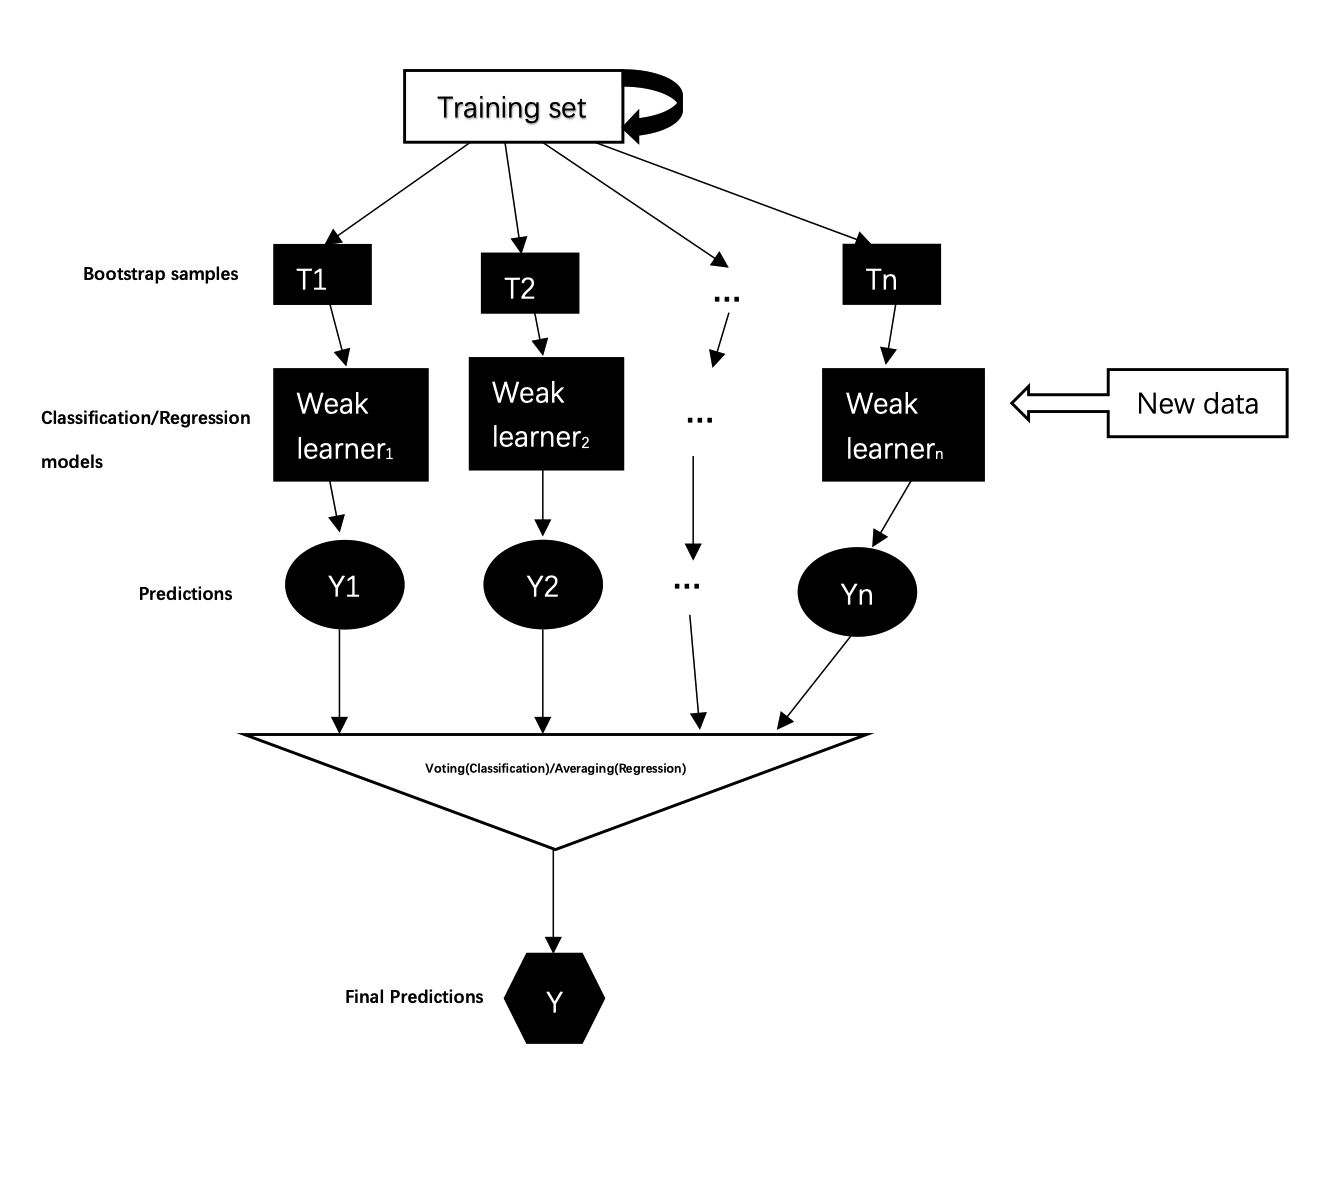

* Bagging works especially well for high-variance and low-bias procedures.

#### Classification with Bagging

* Individual decision trees typically exhibit high variance and tend to overfit, so the decision tree is a good candidate for the weak learner. In this scenario, I choose multiple decision trees as weak learners.

In [ ]:
#Individual decision tree
pipe_dt = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputClassifier(DecisionTreeClassifier()))])

grid_param_dt = {
    'clf__estimator__criterion': ['gini','entropy']
}

gs_dt = (GridSearchCV(estimator=pipe_dt, 
                      param_grid=grid_param_dt, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_dt.fit(X_train,y_train)
print(gs_dt.best_estimator_)   

dtc_predict=gs_dt.predict(X_test)
acc_dtc=accuracy(dtc_predict,y_test)/10
print('Mean error distance of decision tree classifier: '+str(acc_ridge)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                        max_depth=None,
                                                                        max_features=None,
                                                                        max_leaf_nodes=None,
                                                                        min_impurity_decrease=0.0,
                                                                        min_impurity_split=None,
                                                                        min_samples_leaf=1,
                          

We can observe that indeividual decision tree works not that good. Now we will use bagging for classification. 

In [ ]:
#bagging (classification)
class bagging_dtc:
  def __init__(self,n_estimators,max_samples):
    self.n_estimators=n_estimators
    self.max_samples=max_samples
    self.trees=list()
  def fit(self,X_train,y_train):
    fulldata=pd.concat([X_train,y_train],axis=1)
    #bootstrap sampling
    for i in range(self.n_estimators):
      sample=fulldata.sample(round(X_train.shape[0]*self.max_samples),replace=True)
      sample_train=sample.iloc[:,:6]
      sample_test=sample.iloc[:,-2:]
      clf=Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputRegressor(DecisionTreeClassifier(criterion='gini')))])
      tree=clf.fit(sample_train,sample_test)
      self.trees.append(tree)
  def predict(self,X_test):
    predictions=[tree.predict(X_test) for tree in self.trees]
    final_pred_x = []
    final_pred_y = []
    #majority vote
    for i in range(0,len(predictions[0])):
      final_pred_x.append(max_value([value[i][0] for value in predictions]))
      final_pred_y.append(max_value([value[i][1] for value in predictions]))
    final_pred=np.dstack((final_pred_x,final_pred_y))
    final_pred=final_pred.reshape(X_test.shape[0],2)
    return final_pred
bagging_clf=bagging_dtc(n_estimators=100,max_samples=1.0)     
bagging_clf.fit(X_train,y_train)
bagging_clf_predict=bagging_clf.predict(X_test)
acc_bagging_clf=accuracy(bagging_clf_predict,y_test)/10
print('Mean error distance of bagging classifier: '+str(acc_bagging_clf)+'m')
    

Mean error distance of bagging classifier: 2.964332660211403m


When the number of estimators is 100 and train each decision tree on random subsets of the full training data with replacement, the localization accuracy has increased.

In [ ]:
#random forest
rf_clf = Pipeline([('scl', StandardScaler()),
        ('clf', RandomForestClassifier())])
grid_param_rfc = {
     'clf__n_estimators': np.arange(100,200,10),'clf__max_features': ['sqrt', 6]
}
gs_rfc = (GridSearchCV(estimator=rf_clf, 
                      param_grid=grid_param_rfc, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))
gs_rfc.fit(X_train,y_train)
print(gs_rfc.best_estimator_) 
rf_clf_predict=gs_rfc.predict(X_test)
acc_rf_clf=accuracy(rf_clf_predict,y_test)/10
print('Mean error distance of bagging classifier: '+str(acc_rf_clf)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=180, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)
Mean error distance of b

#### Regression with Bagging

In [ ]:
pipe_dtr = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputRegressor(DecisionTreeRegressor()))])

grid_param_dtr = {
    'clf__estimator__criterion': ['mse','mae']
}

gs_dtr = (GridSearchCV(estimator=pipe_dtr, 
                      param_grid=grid_param_dtr, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_dtr.fit(X_train,y_train)
print(gs_dtr.best_estimator_)   

dtr_predict=gs_dtr.predict(X_test)
acc_dt_reg=accuracy(dtr_predict,y_test)/10
print('Mean error distance of decision tree regressor: '+str(acc_dt_reg)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                      criterion='mse',
                                                                      max_depth=None,
                                                                      max_features=None,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                      min_impurity_split=None,
                                                                      min_samples_leaf=1,
                                                                      min_samples_split=2,
                                           

In [ ]:
#bagging (regression)
class bagging_dtr:
  def __init__(self,n_estimators,max_samples):
    self.n_estimators=n_estimators
    self.max_samples=max_samples
    self.trees=list()
  def fit(self,X_train,y_train):
    fulldata=pd.concat([X_train,y_train],axis=1)
    #bootstrap sampling
    for i in range(self.n_estimators):
      sample=fulldata.sample(round(X_train.shape[0]*self.max_samples),replace=True)
      sample_train=sample.iloc[:,:6]
      sample_test=sample.iloc[:,-2:]
      clf=Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputRegressor(DecisionTreeRegressor(criterion='mse')))])
      tree=clf.fit(sample_train,sample_test)
      self.trees.append(tree)
  def predict(self,X_test):
    predictions=[tree.predict(X_test) for tree in self.trees]
    treesnp=np.array(predictions)
    #averaging
    final_pred=treesnp.mean(axis=0)
    return final_pred
bagging_reg=bagging_dtr(n_estimators=10,max_samples=1.0)     
bagging_reg.fit(X_train,y_train)
bagging_reg_predict=bagging_reg.predict(X_test)
acc_bagging_reg=accuracy(bagging_reg_predict,y_test)/10
print('Mean error distance of bagging regressor: '+str(acc_bagging_reg)+'m')
    

Mean error distance of bagging regressor: 2.4835808460005393m


When the number of estimators is 10 and train each decision tree on random subsets of the full training data with replacement, the localization accuracy has increased.

In [ ]:
#random forest regressor
rf_reg = Pipeline([('scl', StandardScaler()),
        ('clf',RandomForestRegressor())])
grid_param_rfr = {
     'clf__n_estimators': np.arange(100,200,10),'clf__max_features': ['sqrt', 6]
}
gs_rfr = (GridSearchCV(estimator=rf_reg, 
                      param_grid=grid_param_rfr, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))
gs_rfr.fit(X_train,y_train)
print(gs_rfr.best_estimator_) 
rf_reg_predict=gs_rfr.predict(X_test)
acc_rf_reg=accuracy(rf_reg_predict,y_test)/10
print('Mean error distance of bagging classifier: '+str(acc_rf_reg)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=150, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)
Mean error distance of bagging classifier: 2.3811367370

### Boosting

#### Classification with adaboosting

In [ ]:
#Adaboost
adaboost_clf = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputClassifier(AdaBoostClassifier()))])
grid_param_adac = {
     'clf__estimator__n_estimators': np.arange(500,1000,100),'clf__estimator__algorithm': ['SAMME', 'SAMME.R']
}
gs_adac = (GridSearchCV(estimator=adaboost_clf, 
                      param_grid=grid_param_adac, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))
gs_adac.fit(X_train,y_train)
print(gs_adac.best_estimator_)
adaboost_predict_clf=gs_adac.predict(X_test)
acc_adaboost_clf=accuracy(adaboost_predict_clf,y_test)/10
print('Mean error distance of AdaBoostClassifier: '+str(acc_adaboost_clf)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                                    base_estimator=None,
                                                                    learning_rate=1.0,
                                                                    n_estimators=900,
                                                                    random_state=None),
                                       n_jobs=None))],
         verbose=False)
Mean error distance of AdaBoostClassifier: 3.6345744770287185m


#### Regression with adaboosting

In [ ]:
adaboost_reg = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputRegressor(AdaBoostRegressor()))])
grid_param_adar = {
     'clf__estimator__n_estimators': np.arange(100,1000,100),'clf__estimator__loss': ['linear', 'square']
}
gs_adac = (GridSearchCV(estimator=adaboost_reg, 
                      param_grid=grid_param_adar, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))
gs_adac.fit(X_train,y_train)
print(gs_adac.best_estimator_)
adaboost_predict_reg=gs_adac.predict(X_test)
acc_adaboost_reg=accuracy(adaboost_predict_reg,y_test)/10
print('Mean error distance of AdaBoostRegressor: '+str(acc_adaboost_reg)+'m')

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=None,
                                                                  learning_rate=1.0,
                                                                  loss='linear',
                                                                  n_estimators=700,
                                                                  random_state=None),
                                      n_jobs=None))],
         verbose=False)
Mean error distance of AdaBoostRegressor: 2.8011329732308967m


#### Regression with XGBboosting

In [ ]:
import xgboost as xgb
param_tuning = {
        'clf__estimator__learning_rate': [0.01, 0.1],
        'clf__estimator__max_depth': [3, 5, 7, 10],
        'clf__estimator__n_estimators' : [100, 200, 500],
    }
xgb_reg = Pipeline([('scl', StandardScaler()),
        ('clf', MultiOutputRegressor(xgb.XGBRegressor()))])
gs_xgb = (GridSearchCV(estimator=xgb_reg, 
                      param_grid=param_tuning, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))
gs_xgb.fit(X_train, y_train)
print(gs_xgb.best_estimator_)
xgb_predict_reg=gs_xgb.predict(X_test)
acc_xgb_reg=accuracy(xgb_predict_reg,y_test)/10
print('Mean error distance of XgbBoostRegressor: '+str(acc_xgb_reg)+'m')

[17:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5,
                                                             booster='gbtree',
                                                             colsample_bylevel=1,
                                                             colsample_bynode=1,
                                                             colsample_bytree=1,
                                                             gamma=0,
                                                             importance_type='gain',
                                             

### Stacking

#### Regression with stacking

In [ ]:
from sklearn.ensemble import StackingRegressor
estimators = [('knn', KNeighborsRegressor(n_neighbors=9,metric='euclidean',weights='distance')),
              ('svr', SVR(kernel='rbf',C=9)),
              ('ridge',Ridge(alpha=1)),
              ('rf', RandomForestRegressor(n_estimators=160,max_features='sqrt')),
              ('ada',AdaBoostRegressor(loss='linear',n_estimators=700))
              ]
reg_stacking = MultiOutputRegressor(StackingRegressor(estimators=estimators, final_estimator = Ridge(alpha=1),cv=10))
stacking_reg = Pipeline([('scl', StandardScaler()),
        ('reg', reg_stacking)])
stacking_reg.fit(X_train,y_train)
stacking_reg['reg'].estimator.final_estimator_ = stacking_reg['reg'].estimator.final_estimator
stacking_predict_reg=stacking_reg.predict(X_test)
acc_stacking_reg=accuracy(stacking_predict_reg,y_test)/10
print('Mean error distance of StackingRegressor: '+str(acc_stacking_reg)+'m') 

Mean error distance of StackingRegressor: 2.4521146213562135m


## Conclusion

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


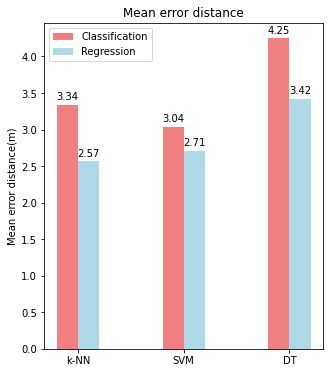

In [ ]:
models = ['k-NN','SVM','DT']
clf_acc=[acc_knnc,acc_svc,acc_dtc]
reg_acc=[acc_knnr,acc_svr,acc_dt_reg]
clf_acc_new=[float(format(value,'.2f')) for value in clf_acc]
reg_acc_new=[float(format(value,'.2f')) for value in reg_acc]
x=np.arange(len(models))
width=0.2
fig,ax = plt.subplots(figsize=(5,6))
rec1=ax.bar(x-width/2,clf_acc_new,width,label='Classification',color='lightcoral')
rec2=ax.bar(x+width/2,reg_acc_new,width,label='Regression',color='lightblue')
ax.set_ylabel('Mean error distance(m)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='upper left')
def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),xy=(rect.get_x()+rect.get_width()/2,height),
                xytext=(0,3),textcoords="offset points",ha='center',va='bottom')
autolabel(rec1)
autolabel(rec2)

fig.savefig('test.eps',dpi=600,format='eps')

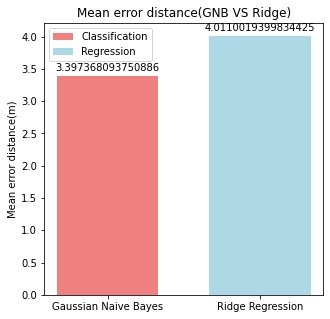

In [ ]:

fig,ax = plt.subplots(figsize=(5,5))
width=0.2
x=[0.1,0.4]
label=['Gaussian Naive Bayes','Ridge Regression']
rect3 = ax.bar(0.1,acc_gn,color='lightcoral',width=width,label='Classification')
rect4 = ax.bar(0.4,acc_ridge,color='lightblue',width=width,label='Regression')
ax.set_xticks(x)
ax.set_xticklabels(label)
ax.legend()
ax.set_ylabel('Mean error distance(m)')
ax.set_title('Mean error distance(GNB VS Ridge)')
autolabel(rect3)
autolabel(rect4)

In conclusion, regression typically performs better than classification in RSSI-based fingerprinting. In terms of ensemble methods, the result has proved that bagging performs better than individual machine learning models, and it achieves the highest localization accuracy. I think the reason why the voting ensemble's accuracy is low is that some of the contributing models are not as good as the other contributing models in the voting ensemble classifier/regressor. As a result, they decrease the overall performance of the voting ensemble classifier/regressor. In order to solve this problem, we can add more contributing models and pay more attention to model selection.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


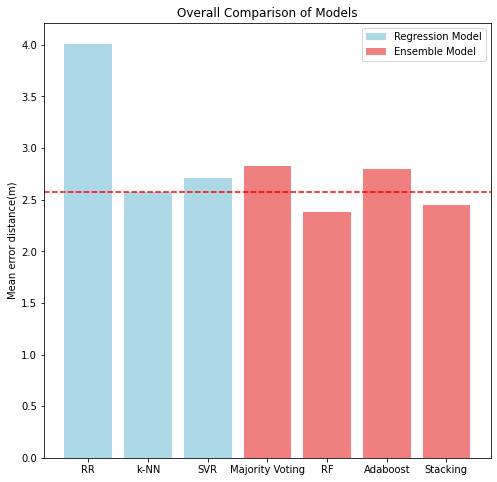

In [ ]:
import matplotlib.pyplot as plt
 
name_list = ['RR','k-NN','SVR']
num_list = [acc_ridge,acc_knnr,acc_svr]
a = ['Majority Voting','RF','Adaboost','Stacking']
b = [2.822,acc_rf_reg,acc_adaboost_reg,acc_stacking_reg]
plt.subplots(figsize=(8,8))
plt.bar(name_list, num_list, label='Regression Model',fc = 'lightblue')
plt.bar(a, b, label='Ensemble Model',fc = 'lightcoral')
plt.axhline(y=acc_knnr, color='red', linestyle='dashed')
plt.title('Overall Comparison of Models')
plt.ylabel('Mean error distance(m)')
plt.legend()
plt.savefig('dyq.eps',dpi=600,format='eps')
plt.show()


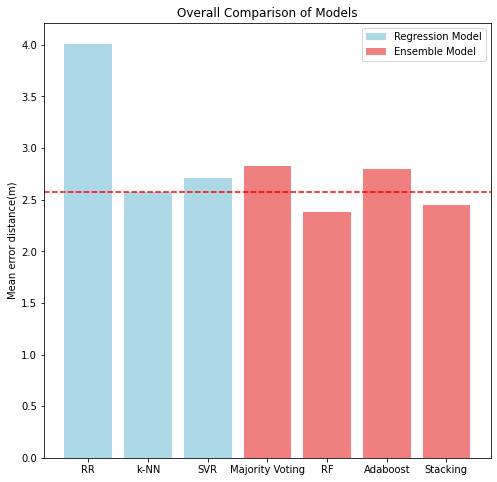

In [ ]:
import matplotlib.pyplot as plt
 
name_list = ['RR','k-NN','SVR']
num_list = [4.011,2.571,2.706]
a = ['Majority Voting','RF','Adaboost','Stacking']
b = [2.822,2.381,2.801,2.452]
plt.subplots(figsize=(8,8))
plt.bar(name_list, num_list, label='Regression Model',fc = 'lightblue')
plt.bar(a, b, label='Ensemble Model',fc = 'lightcoral')
plt.axhline(y=2.571, color='red', linestyle='dashed')
plt.title('Overall Comparison of Models')
plt.ylabel('Mean error distance(m)')
plt.legend()
plt.savefig('dyq.png')
plt.show()